<a href="https://colab.research.google.com/github/uncertainity/Scribble_Shape_Recognition/blob/main/Scribble_Shape_recognition_V1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
from skimage.transform import hough_line,hough_line_peaks
import math
from copy import deepcopy
import os

In [ ]:
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/Scribble Test/"
os.chdir(path)
sub = os.listdir()
print(sub)

['test_6.JPG', 'test_1.JPG', 'test_2.JPG', 'test_3.JPG', 'test_4.JPG', 'test_5.JPG', 'test_7.JPG']


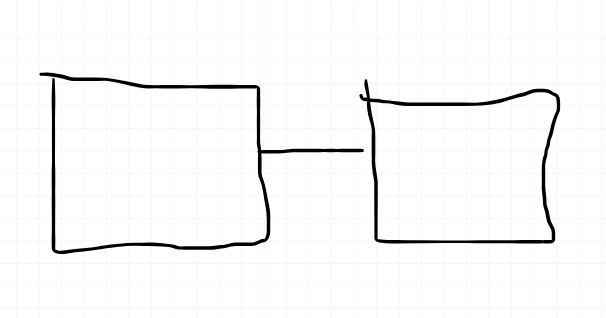

In [ ]:
img = cv2.imread(path + sub[2])
cv2_imshow(img)

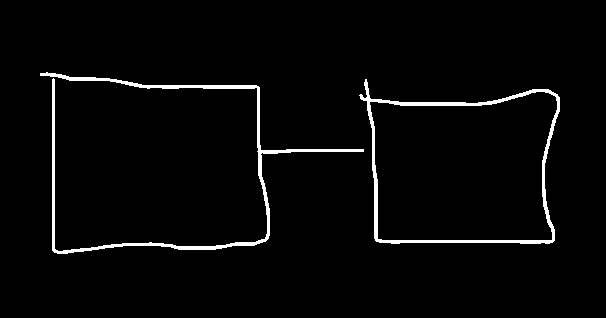

In [ ]:
''' thresholding and converting to binary '''
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cv2_imshow(thresh)

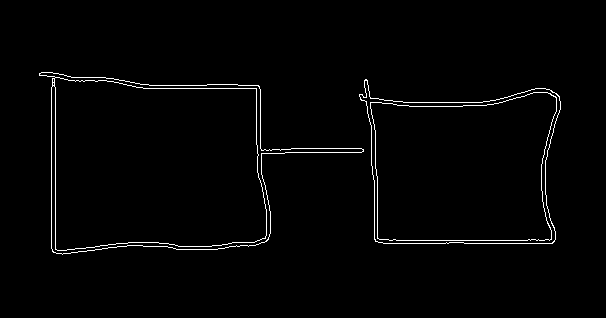

In [ ]:
''' Canny edge detection '''
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(gray, low_threshold, high_threshold)
cv2_imshow(edges)

In [ ]:
''' Hough line transform to get the lines '''
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 50  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments

lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)
lines = np.squeeze(lines)

In [ ]:
''' Hough Lines and preprocessing functions '''
def preprocess(img):
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  ''' Canny edge detection '''
  low_threshold = 50
  high_threshold = 150
  edges = cv2.Canny(gray, low_threshold, high_threshold)
  #cv2_imshow(edges)
  ''' Hough line transform to get the lines '''
  rho = 1  # distance resolution in pixels of the Hough grid
  theta = np.pi / 180  # angular resolution in radians of the Hough grid
  threshold = 50  # minimum number of votes (intersections in Hough grid cell)
  min_line_length = 50  # minimum number of pixels making up a line
  max_line_gap = 20  # maximum gap in pixels between connectable line segments

  lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                      min_line_length, max_line_gap)
  lines = np.squeeze(lines)
  return lines

In [ ]:
''' helper function for detecting and merging hough lines '''

def lineMagnitude(x1, y1, x2, y2):
    'Get line (aka vector) length'
    lineMagnitude = math.sqrt(math.pow((x2 - x1), 2) + math.pow((y2 - y1), 2))
    return lineMagnitude

def DistancePointLine(point, line):
  """Get distance between point and line
  http://local.wasp.uwa.edu.au/~pbourke/geometry/pointline/source.vba
  """
  px, py = point
  x1, y1, x2, y2 = line
  LineMag = lineMagnitude(x1, y1, x2, y2)
  if LineMag < 0.00000001:
    DistancePointLine = 9999
    return DistancePointLine

  u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
  u = u1 / (LineMag * LineMag)
  if (u < 0.00001) or (u > 1):
    #// closest point does not fall within the line segment, take the shorter distance
    #// to an endpoint
    ix = lineMagnitude(px, py, x1, y1)
    iy = lineMagnitude(px, py, x2, y2)
    if ix > iy:
      DistancePointLine = iy
    else:
      DistancePointLine = ix
  else:
    # Intersecting point is on the line, use the formula
    ix = x1 + u * (x2 - x1)
    iy = y1 + u * (y2 - y1)
    DistancePointLine = lineMagnitude(px, py, ix, iy)

  return DistancePointLine

def get_orientation(line):
  '''get orientation of a line, using its length
  https://en.wikipedia.org/wiki/Atan2
  Calculates the angle of a line with respect to the y - axis. Note, there is no concept of negative angles since absolute values are used.
  '''
  orientation = math.atan2(abs((line[0] - line[2])), abs((line[1] - line[3])))
  return math.degrees(orientation)

def get_orientation_orig(line):
  '''get orientation of a line, using its length
  https://en.wikipedia.org/wiki/Atan2
  Calculates the angle of a line with respect to the y - axis. Note, there is negative angles.
  '''
  orientation = math.atan2((line[0] - line[2]), (line[1] - line[3]))
  return math.degrees(orientation)



def get_distance(a_line,b_line):
  ''' Gets distance between two lines '''

  #print(a_line)
  #print(b_line)
  dist1 = DistancePointLine(a_line[:2],b_line)
  dist2 = DistancePointLine(a_line[2:],b_line)
  dist3 = DistancePointLine(b_line[:2],a_line)
  dist4 = DistancePointLine(b_line[2:],a_line)
  #print(dist1,dist2,dist3,dist4)
  return min(dist1,dist2,dist3,dist4)


def checker_base(line_new,groups,min_distance_to_merge,min_angle_to_merge):
  '''' Old function. Not in use. '''
  for group in groups:
    for line_old in group:
      if get_distance(line_old,line_new) < min_distance_to_merge:
        orientation_new = get_orientation(line_new)
        orientation_old = get_orientation(line_old)
        if abs(orientation_new - orientation_old) < min_angle_to_merge:
          group.append(line_new)
          return False
  return True

def checker(line_new,groups,min_distance_to_merge,min_angle_to_merge):
  ''' Check if a new line segment is a part of a group of line segment based on the distance and angle with the lines of the existing group '''

  flag = 0
  for line_old in groups:
    if get_distance(line_old,line_new) < min_distance_to_merge:
      #print("Distance:",get_distance(line_old,line_new))
      orientation_new = get_orientation_orig(line_new)
      orientation_old = get_orientation_orig(line_old)
      if abs(orientation_new - orientation_old) < min_angle_to_merge:
        #print(line_old)
        #print(line_new)
        #print("Angle:",orientation_new - orientation_old)
        groups.append(line_new)
        flag = 1
        break
  return groups,flag


def merge_lines_pipelines_1(lines):
  '''Find out similar line segments based on distance and angles for each line using func "checker" '''

  groups_all = []
  idx_all = []
  min_distance_to_merge = 30
  min_angle_to_merge = 15

  for i in range(len(lines)):
    groups = []
    idx = []
    groups.append(lines[i])
    idx.append(i)
    for j in range(i+1,len(lines)):
      groups,flag = checker(lines[j],groups,min_distance_to_merge,min_angle_to_merge)
      if flag == 1:
        idx.append(j)
    groups_all.append(groups)
    idx_all.append(idx)
  return groups_all,idx_all

## probably not in use - can be ommited ##
def merge_lines_pipelines_2(lines):
  '''Old function. Not is use. '''
  groups_all,idx_all = merge_lines_pipelines_1(lines)
  occured_idx = []
  groups = []
  for i in range(len(idx_all)):
    g = []
    group = []
    if i not in occured_idx:
      occured_idx.append(i)
      for j in idx_all[i]:
        g += idx_all[j]
        occured_idx.append(j)
    g = list(set(g))
    #print(g)
    if len(g) > 0:
      for idx in g:
        group.append(lines[idx])
      groups.append(group)
  return groups


def merge_lines_pipelines_3(lines):
  ''' Groups together similar line segments based on distance and angle'''
  groups_all,idx_all = merge_lines_pipelines_1(lines)
  all = list(np.arange(len(idx_all)))
  delete_list = []
  groups = []
  for i in range(len(all)):
    if i not in delete_list:
      g = []
      group = []
      list_1 = idx_all[i]
      delete_list.append(i)
      for j in range(len(all)):
        if j not in delete_list:
          list_2 = idx_all[j]
          if len(set(list_1) & set(list_2)) > 0:
            list_1 = list_1 + list_2
            delete_list.append(j)
      #print(delete_list)
      #print(set(list_1))
      g = g + list(set(list_1))
      #print(g)
      if len(g) > 0:
        for idx in g:
          group.append(lines[idx])
        groups.append(group)
    #break
  return groups


def merge_line_segments(group):
  ''' Represents a group of line segments using a single line. I have forgotten how the function works :( '''
  orientation = get_orientation(group[0])
  if len(group) == 1:
    return np.block([[group[0][:2],group[0][2:]]])
  points = []
  for line in group:
    points.append(line[:2])
    points.append(line[2:])
  if 45 < orientation <=90:
    points = sorted(points,key = lambda point: point[1])
  else:
    points = sorted(points,key = lambda point: point[0])
  return np.block([[points[0],points[-1]]])

def post_process(lines):
  ''' merges hough lines to create cleaner representations '''
  groups_lines = merge_lines_pipelines_3(lines)
  new_lines = []
  for group in groups_lines:
    new_lines.append(merge_line_segments(group))
  return new_lines


In [ ]:
''' helped function for joining lines '''

def segments_distance(x11, y11, x12, y12, x21, y21, x22, y22):
  """ distance between two segments in the plane:
      one segment is (x11, y11) to (x12, y12)
      the other is   (x21, y21) to (x22, y22)
  """
  if segments_intersect(x11, y11, x12, y12, x21, y21, x22, y22): return 0
  # try each of the 4 vertices w/the other segment
  distances = []
  distances.append(point_segment_distance(x11, y11, x21, y21, x22, y22))
  distances.append(point_segment_distance(x12, y12, x21, y21, x22, y22))
  distances.append(point_segment_distance(x21, y21, x11, y11, x12, y12))
  distances.append(point_segment_distance(x22, y22, x11, y11, x12, y12))
  return min(distances)


def segments_intersect(x11,y11,x12,y12,x21,y21,x22,y22):
  dx1 = x12 - x11
  dy1 = y12 - y11
  dx2 = x22 - x21
  dy2 = y22 - y21
  delta = dx2*dy1 - dy2*dx1
  s = (dx1 * (y21 - y11) + dy1 *(x11 - x21))/delta
  t = (dx2 * (y11 - y21) + dy2 *(x21 - x11))/ (-delta)
  return ( 0 <= s <= 1) and (0 <= t <= 1)

def point_segment_distance(px,py,x1,y1,x2,y2):
  dx = x2 - x1
  dy = y2 - y1
  if dx == dy == 0:
    return math.hypot(px - x1,py - y1)
  t = ((px - x1) * dx + (py - y1) * dy) / (dx * dx + dy * dy)
  if t < 0:
    dx = px - x1
    dy = py - y1
  elif t > 1:
    dx = px - x2
    dy = py - y2
  else:
    near_x = x1 + t * dx
    near_y = y1 + t * dy
    dx = px - near_x
    dy = py - near_y

  return math.hypot(dx, dy)

def shortest_distance_lines(a_line,b_line):
  '''shortest distance between two lines'''
  x11,y11 = a_line[2:]
  x12,y12 = a_line[:2]
  x21,y21 = b_line[2:]
  x22,y22 = b_line[:2]
  #print(x11, y11, x12, y12, x21, y21, x22, y22)
  return segments_distance(x11, y11, x12, y12, x21, y21, x22, y22)


def get_coords(line,type_ = 1):
  ''' Something to do with arranging the coordinates of each line based on whether they are vertical or horizontal. Left untouched if neither(probably)'''
  if type_ == 1:
    if line[0] < line[2]:
      x1 = line[0]
      y1 = line[1]
      x2 = line[2]
      y2 = line[3]
    else:
      x1 = line[2]
      y1 = line[3]
      x2 = line[0]
      y2 = line[1]
  else:
    if line[1] < line[3]:
      x1 = line[0]
      y1 = line[1]
      x2 = line[2]
      y2 = line[3]
    else:
      x1 = line[2]
      y1 = line[3]
      x2 = line[0]
      y2 = line[1]
  return np.array([x1,y1,x2,y2])


def length_line(line):
  '''Finds out the length of the line'''
  x1,y1 = line[2:]
  x2,y2 = line[:2]
  return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def length_points(points):
  '''Finds out the length between two points. Replica of length line but has a different form of argument'''
  x1,y1 = points[0]
  x2,y2 = points[1]
  return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def post_process_2(line,min_angle_keep = 15):
  ''' Makes near horizontal or vertical lines completely horizontal (0 degree) or vertical (90 degree)'''
  orientation = get_orientation(line)
  #print(orientation)
  length = length_line(line)
  #print(line)
  if np.abs(0 - orientation) < min_angle_keep:
    line = get_coords(line,type_ = 2)
    x1 = line[0]
    y1 = line[1]
    x2 = x1
    y2 = y1 + int(length)
  elif np.abs(90 - orientation) < min_angle_keep:
    line = get_coords(line,type_ = 1)
    x1 = line[0]
    y1 = line[1]
    x2 = x1 + int(length)
    y2 = y1
  else:
    x1 = line[0]
    y1 = line[1]
    x2 = line[2]
    y2 = line[3]
  return np.array([x1,y1,x2,y2])

def perp(a) :
  b = np.empty_like(a)
  b[0] = -a[1]
  b[1] = a[0]
  return b

# line segment a given by endpoints a1, a2
# line segment b given by endpoints b1, b2
# return

def seg_intersect(a_line,b_line) :
  '''Finds out the intersection point of two lines'''
  a1 = a_line[:2].astype(float)
  a2 = a_line[2:].astype(float)
  b1 = b_line[:2].astype(float)
  b2 = b_line[2:].astype(float)
  da = a2-a1
  db = b2-b1
  dp = a1-b1
  dap = perp(da)
  denom = np.dot(dap, db)
  num = np.dot( dap, dp)
  if denom == 0:
    return True,[np.inf,np.inf]

  return False,(num / denom.astype(float))*db + b1

def check_point_on_segment(line,p):
  '''Checks whether the point p is on line segment line'''
  if length_points([line[:2],p]) + length_points([line[2:],p]) == length_points([line[:2],line[2:]]):
    return True
  else:
    return False


def joining_lines(post_lines,min_distance_join = 100):
  '''For each line, other lines less than a certain distance from the line are found out and joined with the line'''

  test_lines = deepcopy(post_lines)
  #print(post_lines)
  min_distances_join = 100
  for i in range(len(test_lines)):
    line_0 = test_lines[i]
    for j in range(len(test_lines)):
      if i != j:
        line_1 = test_lines[j]
        distance = get_distance(line_0,line_1)
        if distance < min_distance_join:
          parallel,p = seg_intersect(line_0,line_1)
          #p = np.round(p,2)
          if parallel == False and shortest_distance_lines(line_0,line_1) > 0:
            if check_point_on_segment(line_0,p):
              if length_points([line_1[2:],p]) < length_points([line_1[:2],p]):
                line_1[2:] = p
              else:
                line_1[:2] = p
            elif check_point_on_segment(line_1,p):
              if length_points([line_0[2:],p]) < length_points([line_0[:2],p]):
                line_0[2:] = p
              else:
                line_0[:2] = p
            else:
              if length_points([line_0[2:],p]) < length_points([line_0[:2],p]):
                  line_0[2:] = p
              else:
                  line_0[:2] = p
              if length_points([line_1[2:],p]) < length_points([line_1[:2],p]):
                line_1[2:] = p
              else:
                line_1[:2] = p
            test_lines[i] = line_0
            test_lines[j] = line_1
  #print(post_lines)
  return test_lines


In [ ]:
''' post processing after joining lines '''

def post_process_3(test_lines,min_distance_keep = 50,min_angle_keep = 5):
  delete_list = []
  for i in range(len(test_lines)):
    if i not in delete_list:
      for j in range(len(test_lines)):
        if np.abs(get_orientation(test_lines[i]) - get_orientation(test_lines[j])) < min_angle_keep and get_distance(test_lines[i],test_lines[j]) < min_distance_keep and i != j:
          delete_list.append(j)
  test_lines_1 = []
  for i in range(len(test_lines)):
    if i not in delete_list:
      test_lines_1.append(test_lines[i])
  return test_lines_1

def post_process_4(test_lines_1,min_distance_point_keep = 20):
  '''Closure algorithm. Detects if end points of each line is connected to other lines. If not, tries to figure out the line closest to the end point of the open line and
    connects it to the closest line. Probably needs a lot of testing based on edge cases.'''

  not_closed = []
  for i in range(len(test_lines_1)):
    line_1 = test_lines_1[i]
    point_1 = line_1[:2]
    point_2 = line_1[2:]
    count = 0
    for j in range(len(test_lines_1)):
      if i != j:
        line_2 = test_lines_1[j]
        line_id = []

        p,intersec_point = seg_intersect(line_1,line_2)
        if p == False and check_point_on_segment(line_1,intersec_point) and check_point_on_segment(line_2,intersec_point) and (length_points([line_1[:2],intersec_point]) < min_distance_point_keep or
                                                                                                                              length_points([line_1[2:],intersec_point]) < min_distance_point_keep):
          count += 1
    if count < 2:
      not_closed.append(i)
  #print(not_closed)

  distance_lines = np.zeros((len(not_closed),len(not_closed)))
  for i in range(len(not_closed)):
    for j in range(i+1,len(not_closed)):
      distance_lines[i,j] = get_distance(test_lines_1[not_closed[i]],test_lines_1[not_closed[j]])
      distance_lines[j,i] = get_distance(test_lines_1[not_closed[i]],test_lines_1[not_closed[j]])
      if distance_lines[i,j] < 10:
        distance_lines[i,j] = 0
        distance_lines[j,i] = 0

  #print(distance_lines)

  make_pair = []
  delete_list = []
  for i in range(distance_lines.shape[0]):
    if i not in delete_list:
      sorted_values = np.argsort(distance_lines[i])
      for s in sorted_values:
        if distance_lines[i][s] != 0:
          make_pair.append([not_closed[i],not_closed[s]])
          delete_list.append(i)
          delete_list.append(s)
          break
  #print(make_pair)
  for pair in make_pair:
    line_1 = test_lines_1[pair[0]]
    line_2 = test_lines_1[pair[1]]
    p,intersec_point = seg_intersect(line_1,line_2)
    #print(p)
    if p == False:
      if length_points([line_1[:2],intersec_point]) < length_points([line_1[2:],intersec_point]):
        test_lines_1[pair[0]][:2] = intersec_point
      else:
        test_lines_1[pair[0]][2:] = intersec_point
      if length_points([line_2[:2],intersec_point]) < length_points([line_2[2:],intersec_point]):
        test_lines_1[pair[1]][:2] = intersec_point
      else:
        test_lines_1[pair[1]][2:] = intersec_point

  return test_lines_1


In [ ]:
def run_all_postprocessing(lines):
  lines = np.squeeze(lines)
  new_lines = post_process(lines)
  post_lines = []
  for line in new_lines:
    line = np.squeeze(line)
    post_lines.append(post_process_2(line))
  test_lines = joining_lines(post_lines)
  # for i in range(refinement_rep):
  #   test_lines = joining_lines_wo_condition(test_lines)
  test_lines = post_process_3(test_lines)
  test_lines = post_process_4(test_lines)
  return lines,new_lines,post_lines,test_lines

In [ ]:
def main(img):
  lines = preprocess(img)
  lines,new_lines,post_lines,test_lines = run_all_postprocessing(lines)
  line_image = np.copy(img) * 0
  i = 0
  for line in test_lines:
    #line = np.squeeze(line)
    x1 = line[0]
    y1 = line[1]
    x2 = line[2]
    y2 = line[3]
    cv2.line(line_image,(x1,y1),(x2,y2),(255,255,255),2)
    # i += 1
    # if i > 1:
    #    break
  cv2_imshow(line_image)
  #line_image_post = deepcopy(line_image)
  return line_image

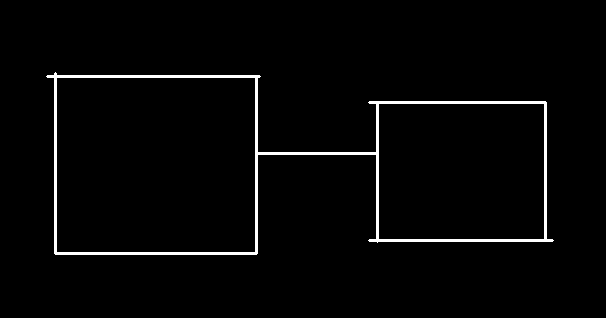

In [ ]:
line_image = main(img)

In [ ]:
''' Hyperparameter watch '''
'''
checker( min_distance_to_merge,min_angle_to_merge)

joining_lines(min_distance_join)

post_process_2(min_angle_keep)

post_process_3(min_distance_keep,  min_angle_keep)

post_process_4(min_distance_point_keep)

'''

'''It might be possible to make the hyperparameter a function of size of the image '''

